# Language Model with LSTM architecture


*   Zihadul Azam
*   Id: 221747
*   zihadul.azam@studenti.unitn.it



This example trains a multi-layer RNN-LSTM on a language modeling task. I have used `Tensorflow Keras` to implement it.

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, TimeDistributed, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

## Params

In [2]:
epochs = 100
batch_size = 20
seq_size = 35

emb_size = 500
hidden_size = 500
num_layers = 2

dropout_rate = 0.5

## Load Data

### Set data folder path here:

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data_path = '/content/drive/MyDrive/nlu-data'
train_path = data_path + '/train.txt'
valid_path = data_path + '/valid.txt'
test_path = data_path + '/test.txt'

In [5]:
# read file and tokenize
def read_file(path):
  result = []
  with open(path, 'r') as file:
    for line in file:
        # add <eos> tag at the end of every sent
        for word in line.split() + ['<eos>']:
          result.append(word)
  return result

In [6]:
# this dictionary maps word to idx
word2int = {}

# this is a list of words, maps idx to word
# e.g. int2word[0] will return '<unk>'
int2word = []

def convertWord2Int(word):
  return word2int[word]

def convertInt2Word(int_v):
  return int2word[int_v]

Make vocabulary from a list of words

In [7]:
def make_vocab(word_list):
  # create vocab set
  vocab = set()
  for token in word_list:
    vocab.add(token)

  sorted_vocab = sorted(list(vocab))
  for i, v in enumerate(sorted_vocab):
    word2int[v] = len(word2int)
  
  for key, _ in word2int.items():
    int2word.append(key)

In [8]:
def data_loader(path, is_make_vocab=False):
  # read file and tokenize
  words = read_file(path)
  
  # make vocab
  if is_make_vocab:
    make_vocab(words)

  # transform word list to int list
  words_int = [convertWord2Int(w) for w in words]

  return words_int

In [9]:
def make_dataset(seq):
    input = seq[:-1]
    target = seq[1:]
    return input, target

def SeqAndBatch(data, batch_size, seq_size):
  # convert to tensor
  data = tf.data.Dataset.from_tensor_slices(data)

  # make sequences
  sequences = data.batch(seq_size+1, drop_remainder=True)

  # make input and target
  dataset = sequences.map(make_dataset)

  # make batch
  data = dataset.batch(batch_size, drop_remainder=True).repeat()
  AUTOTUNE = tf.data.AUTOTUNE # for performance optimization
  data = data.prefetch(AUTOTUNE)
  
  return data

Load Train, Val and Test data from files

In [10]:
train_idx_list = data_loader(train_path, is_make_vocab= True)
val_idx_list = data_loader(valid_path, is_make_vocab=False)
test_idx_list = data_loader(test_path, is_make_vocab=False)

vocab_size = len(int2word)
unk_idx = convertWord2Int('<unk>')

print('Vocabulary size: ', vocab_size)
print('<unk> index: ', unk_idx)
print('<unk> tag from idx: ', convertInt2Word(unk_idx))

Vocabulary size:  10000
<unk> index:  44
<unk> tag from idx:  <unk>


Make sequences and batchify

In [11]:
# make sequences and batches
train_dataset = SeqAndBatch(train_idx_list, batch_size, seq_size)
val_dataset = SeqAndBatch(val_idx_list, batch_size, seq_size)
test_dataset = SeqAndBatch(test_idx_list, batch_size, seq_size)

Below we can see that, the target sequence is made with input sequence values left shifted by one position.

In [12]:
for i, t in train_dataset.take(1):
  print('Input sequence:')
  print(i[0].numpy())
  print('Target sequence:')
  print(t[0].numpy())

Input sequence:
[ 237  807  950 1325 1476 1691 3773 3920 4067 4380 4731 4922 5569 5732
 5876 7091 7175 7366 7769 8203 8301 8478 8819 9658   43 6605   44   45
 9965 6172 9838 4833 9012 1040  609]
Target sequence:
[ 807  950 1325 1476 1691 3773 3920 4067 4380 4731 4922 5569 5732 5876
 7091 7175 7366 7769 8203 8301 8478 8819 9658   43 6605   44   45 9965
 6172 9838 4833 9012 1040  609   48]


In [13]:
for i, t in train_dataset.take(1):
  print('Input first batch:')
  print(i.numpy())
  print()
  print('Target first batch:')
  print(t.numpy())

Input first batch:
[[ 237  807  950 1325 1476 1691 3773 3920 4067 4380 4731 4922 5569 5732
  5876 7091 7175 7366 7769 8203 8301 8478 8819 9658   43 6605   44   45
  9965 6172 9838 4833 9012 1040  609]
 [6033 2631 6074   45   43 5825   44 4748 1493 6142   44 5869 9012 2888
  7076 4028   43 7774   44   45 9965 6172  424 3687 1493 6142 1968 3947
  3506 6667 9705 5881   48 6033 2631]
 [9048 1180 4542 1927   43   48 3681 6142  611 6187 9504 9119 5378 4913
  1604 3529 4144 1444   48 4233 6499 6142 1349 2353  404   48 4028 6142
  9905 3332 9119 4764 5782 9007   45]
 [ 287 7516 7480   43 9012  611 3501   44 4748 9467   44 6187 4764 3105
  9012   44 9869 3203 1166 3334 9119 4764 1446 8846 9010 8161 9474 2368
  5034 7516 7824   43   44 4477 9012]
 [6142 5975 9978   44 2096 9010 5381 4913 1605 8597 9510   44 4470 4770
    44 1604 3529 4470   45   43  379 6816 3545 9779 7480 5782 9007   48
  9958  287 9012 5035 7586  498 4470]
 [   9 5975 3086 4851 6142 5551   48 3697 5180 9119 1173 5975  684 9119

In [14]:
for i, t in train_dataset.take(1):
  print('Single batch Input dataset shape:')
  print(i.numpy().shape)
  print('Single batch Target dataset shape:')
  print(t.numpy().shape)

Single batch Input dataset shape:
(20, 35)
Single batch Target dataset shape:
(20, 35)


## Model

Create LSTM Model

In [15]:
def create_model(vocab_size, emb_size, hidden_size, batch_size, seq_size, num_layers, dropout_rate):
  model = Sequential()

  # embedding layer
  model.add(Embedding(vocab_size, emb_size, batch_input_shape=(batch_size, None)))

  # lstm layers
  for i in range(num_layers):
    model.add(LSTM(hidden_size, return_sequences= True))
    model.add(Dropout(dropout_rate))

  # fc layer
  model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

  return model

In [16]:
model = create_model(vocab_size, emb_size, hidden_size, batch_size, seq_size, num_layers, dropout_rate)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (20, None, 500)           5000000   
_________________________________________________________________
lstm (LSTM)                  (20, None, 500)           2002000   
_________________________________________________________________
dropout (Dropout)            (20, None, 500)           0         
_________________________________________________________________
lstm_1 (LSTM)                (20, None, 500)           2002000   
_________________________________________________________________
dropout_1 (Dropout)          (20, None, 500)           0         
_________________________________________________________________
time_distributed (TimeDistri (20, None, 10000)         5010000   
Total params: 14,014,000
Trainable params: 14,014,000
Non-trainable params: 0
____________________________________________

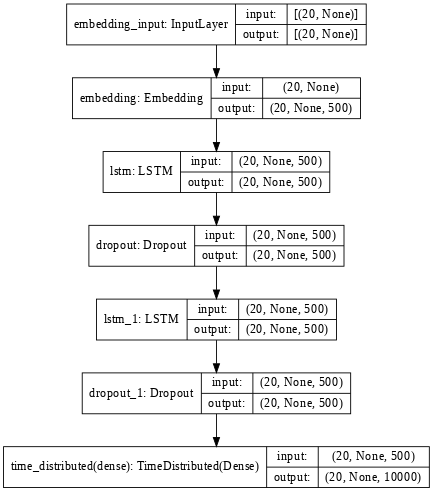

In [17]:
plot_model(model, show_shapes=True, dpi=64)

## Train

Define perplexity function

In [18]:
# perplexity function
def ppl(y_true, y_pred):
  cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = K.exp(K.mean(cross_entropy))
  return perplexity

In [19]:
steps_per_epoch = ((len(train_idx_list)// seq_size)) // batch_size
validation_steps = ((len(val_idx_list)// seq_size)) // batch_size
test_steps = ((len(test_idx_list)// seq_size)) // batch_size

print('Train steps per epoch',steps_per_epoch)
print('Val steps per epoch',validation_steps)
print('Test steps per epoch',test_steps)

Train steps per epoch 1327
Val steps per epoch 105
Test steps per epoch 117


### Start training model

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy', ppl])
history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[early_stopping], validation_data=(val_dataset), validation_steps=validation_steps)

Epoch 1/100
1327/1327 [==============================] - 110s 76ms/step - loss: 6.4803 - sparse_categorical_accuracy: 0.0966 - ppl: 753.4997 - val_loss: 5.8998 - val_sparse_categorical_accuracy: 0.1485 - val_ppl: 382.7156
Epoch 2/100
1327/1327 [==============================] - 99s 75ms/step - loss: 5.7062 - sparse_categorical_accuracy: 0.1638 - ppl: 317.5786 - val_loss: 5.5245 - val_sparse_categorical_accuracy: 0.1808 - val_ppl: 266.7496
Epoch 3/100
1327/1327 [==============================] - 100s 75ms/step - loss: 5.3876 - sparse_categorical_accuracy: 0.1855 - ppl: 232.6423 - val_loss: 5.3336 - val_sparse_categorical_accuracy: 0.1992 - val_ppl: 225.1757
Epoch 4/100
1327/1327 [==============================] - 100s 75ms/step - loss: 5.1813 - sparse_categorical_accuracy: 0.2000 - ppl: 190.4002 - val_loss: 5.1923 - val_sparse_categorical_accuracy: 0.2090 - val_ppl: 196.6041
Epoch 5/100
1327/1327 [==============================] - 98s 74ms/step - loss: 5.0326 - sparse_categorical_accura

### Show Plots

dict_keys(['loss', 'sparse_categorical_accuracy', 'ppl', 'val_loss', 'val_sparse_categorical_accuracy', 'val_ppl'])


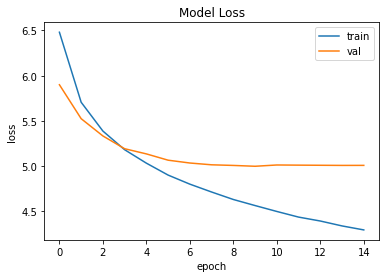

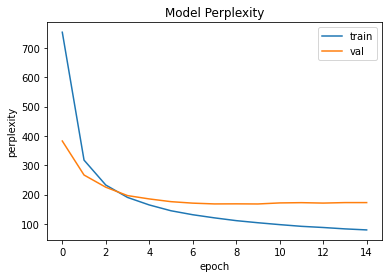

In [22]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


# summarize history for ppl
plt.plot(history.history['ppl'])
plt.plot(history.history['val_ppl'])
plt.title('Model Perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Test

In [23]:
# test after training
test_info = model.evaluate(test_dataset, batch_size=batch_size, steps=test_steps)

print(test_info)
print('Test loss: {0}'.format(test_info[0]))
print('Test perplexity: {0}'.format(K.exp(test_info[0])))

117/117 [==============================] - 2s 16ms/step - loss: 4.8960 - sparse_categorical_accuracy: 0.2360 - ppl: 146.2140
[4.895975589752197, 0.23603174090385437, 146.21400451660156]
Test loss: 4.895975589752197
Test perplexity: 133.7504425048828


### Experiments
I have tried different configurations by changing embedding size and hidden size. Here are the results:

Embedding size  | Hidden size | Early stopped (epoch) | Test loss | Test PPL 
----------------|-------------|-----------------------|-----------|---------
350             |350          | 26                    |4.962      |142.900
350             |1024         | 12                    |4.997      |147.915
500             |500          | 15                    |4.896      |133.750
650             |650          | 17                    |4.950      |141.175

---


## [Appendix] Text Generator
Just for exercise.

In [24]:
model.reset_states()

def text_generator(model, batch_size, seq_size, seeds='the company has', num_words = 50, temp=0.65):
  # tokenize
  seeds_int = []
  for t in seeds.split():
    seeds_int.append(convertWord2Int(t) if t in word2int else unk_idx)

  result = seeds_int
  seeds_tensor = tf.expand_dims(seeds_int, 0)
  seeds_tensor = tf.repeat(seeds_tensor, batch_size, axis=0)

  for i in range(num_words):
    pred = model(seeds_tensor)
    pred = pred[0].numpy()/temp
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    result.append(pred)
    seeds_tensor = result[-seq_size:]
    seeds_tensor = tf.expand_dims([pred],0)
    seeds_tensor = tf.repeat(seeds_tensor, batch_size, axis=0)

  my_text = [convertInt2Word(i) for i in result]
  return ' '.join(my_text)
    
sample_text = text_generator(model, batch_size, seq_size)
print(sample_text)

the company has reiterated ron flush problem dragging resistance favorable sheets greeted tariffs jeffrey australia xtra mutual-fund combine ordinary courter u.n. lone brian persuade our premises distributors seeks genetic newsletters concludes daughter subordinate injury apartment romantic fluor transaction lenders snow helmut accord significance roughly fool sens. glare ark dam haul worrisome teller jr.
